In [3]:
import os
os.chdir("..")
import scanpy as sc
import numpy as np

import datapre as DP
from model import nn_model
from model import hyper_opt as hop
import evaluation as eval

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 1
dirname = "mouse_brain_sagittal_anterior"

In [4]:
NEIGHBOR_DIS = 1.0

/home/huggs/anaconda3/envs/rapids_nwt/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


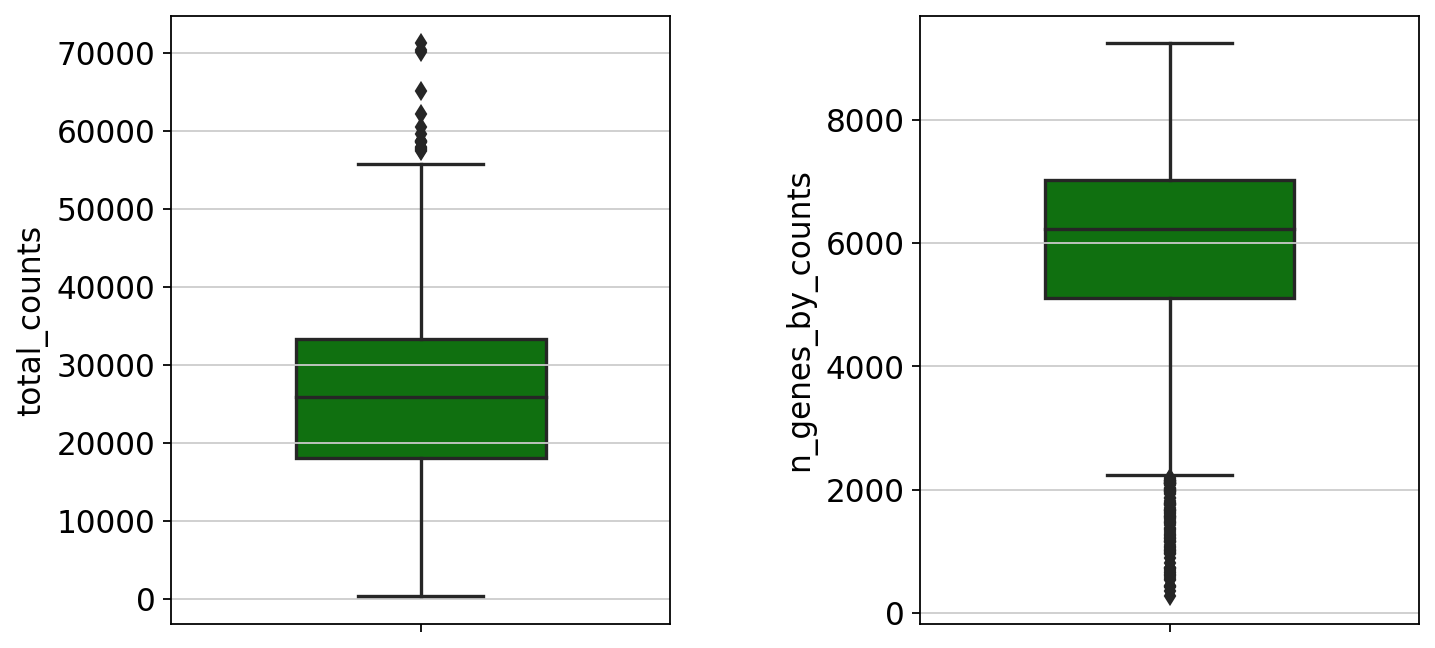

In [5]:
adata = sc.datasets.visium_sge(sample_id = "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars = ["mt"], inplace = True)
DP.feature_plot(adata)

In [4]:
import gc
adata_copy = adata.copy()
sc.pp.normalize_total(adata_copy)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(adata_copy, flavor = "seurat", n_top_genes = 2000)
sc.pp.scale(adata_copy, max_value = 10)
sc.pp.pca(adata_copy)
sc.pp.neighbors(adata_copy, n_neighbors = 20, n_pcs = 30)
sc.tl.umap(adata_copy, n_components = 30)
sc.tl.leiden(adata_copy, resolution = 0.9, key_added = "clusters")

adata.obs["clusters"] = adata_copy.obs.clusters
del adata_copy
gc.collect()

29012

In [5]:
sc.pp.filter_genes(adata, min_counts = 10)

In [6]:
DP.setup_seed(38)

In [7]:
import pickle
with open(dirname + "/sel_feature.pkl", "rb") as file:
    spagene = pickle.load(file)

In [8]:
train_data, test_data, tt_data = DP.dataset_blind(adata, spagene, NEIGHBOR_DIS, neg_size = None)

import imb
marked_neg_index = imb.eliminate_BD_neg(train_data.feature, train_data.label)

In [18]:
from scipy.spatial.distance import cdist
def f1(u, v, **kwargs):
    u = u.reshape(1, -1)
    n = int(u.shape[1]/2)
    u_t = np.concatenate((u[:, n:], u[:, :n]), 1)
    v = v.reshape(1, -1)
    d1 = cdist(u, v, **kwargs)
    d2 = cdist(u_t, v, **kwargs)
    return min(d1, d2)

def f2(u, v):
    n = int(u.shape[0]/2)
    u_t = np.concatenate((u[n:], u[:n]))
    d1 = np.linalg.norm(u - v)
    d2 = np.linalg.norm(u_t - v)
    return min(d1, d2)

def f3(u, v):
    return np.linalg.norm(u - v)

def f4(u, v):
    return cdist(u.reshape(1, -1), v.reshape(1, -1))

np.linalg.norm > cdist > 默认

cdist实际执行计算的底层C代码是使用float64位，传入np.float32数组时，必须复制数据增加时间

In [10]:
# 默认不指定距离函数
%timeit -r 10 -n 1 dis = cdist(train_data.feature[train_data.label][[1000]], train_data.feature)[0]

1min 22s ± 12.7 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [11]:
# cdist
%timeit -r 10 -n 1 dis = cdist(train_data.feature[train_data.label][[1000]], train_data.feature, f4)[0]

27.4 s ± 6.47 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [12]:
# np.linalg.norm
%timeit -r 10 -n 1 dis = cdist(train_data.feature[train_data.label][[1000]], train_data.feature, f3)[0]

12.4 s ± 59.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


本案例

合并不如分开，还是np.linalg.norm更好

In [13]:
# np.linalg.norm real
%timeit -r 10 -n 1 dis = cdist(train_data.feature[train_data.label][[1000]], train_data.feature, f2)[0]

30.2 s ± 102 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [15]:
a = train_data.feature[train_data.label][[1000]].reshape(1, -1)
n = int(a.shape[1]/2)
a_t = np.concatenate((a[:, n:], a[:, :n]), 1)

In [16]:
# 分开
%%timeit -r 10 -n 1
dis = cdist(a, train_data.feature, f3)[0]
dis_2 = cdist(a_t, train_data.feature, f3)[0]
np.minimum(dis, dis_2)

25 s ± 220 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [19]:
# cdist real
%timeit -r 10 -n 1 dis = cdist(train_data.feature[train_data.label][[1000]], train_data.feature, f1)[0]

46.9 s ± 1.44 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


cdist实际执行计算的底层C代码是使用float64位，传入np.float32数组时，必须复制数据增加时间

特征选择，距离度量

neg_size = 30 + class_weight = [1, 3]：0.045 + 0.958\
neg_size = 20 + class_weight = [1, 2]：0.046 + 0.929\
neg_size = 10 + class_weight = [1, 1]：0.044 + 0.915